In [1]:
import sys
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils

In [31]:
def debug_plot_cv_img(img, cmap='gray'):
    fig, ax = plt.subplots(figsize=(2, 4))
    ax.imshow(img, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

In [3]:
def to_binary(img, blockSize=11, constant=2):
    if len(img.shape) > 2:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    binary = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, blockSize, constant)
    return binary

In [4]:
def denoise(img, strength=3, output=None, templateWindowSize=7, searchWindowSize=21):
    return cv.fastNlMeansDenoising(img, output, strength, templateWindowSize, searchWindowSize)

In [5]:
img = cv.imread("../data/20.png")
img = img[250:2300, 120:1000]
# debug_plot_cv_img(img)

In [6]:
def dilate(img, kernel_size=2, kernel=None):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size)) if kernel is None else kernel
    return cv.dilate(img, kernel)
    
def erode(img, kernel_size=2, kernel=None):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size)) if kernel is None else kernel
    return cv.erode(img, kernel)

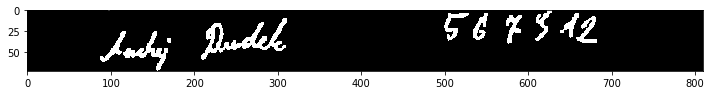

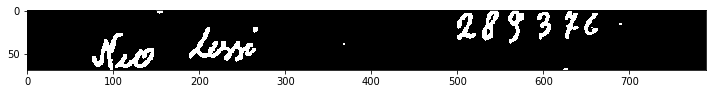

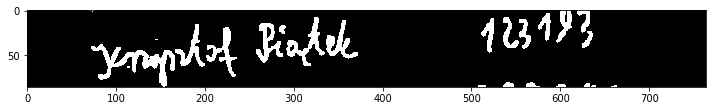

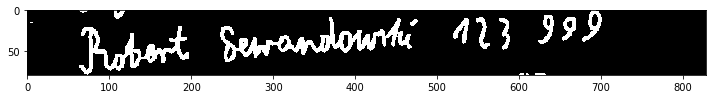

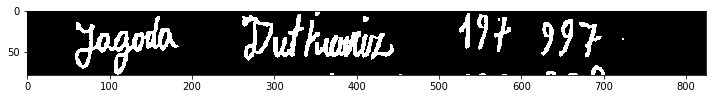

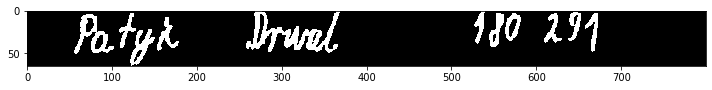

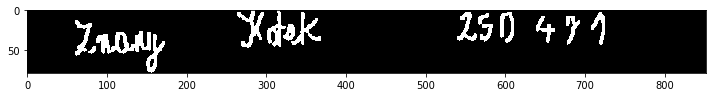

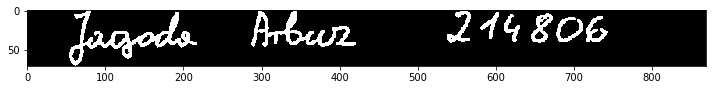

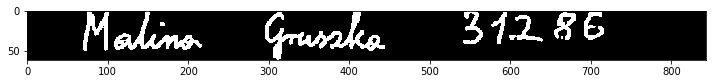

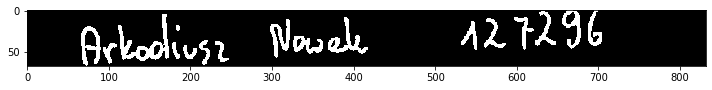

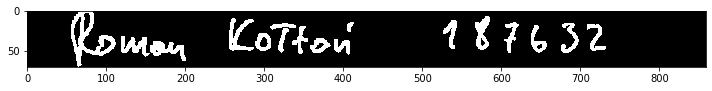

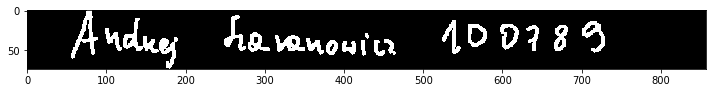

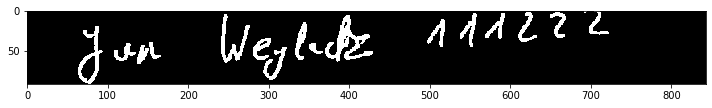

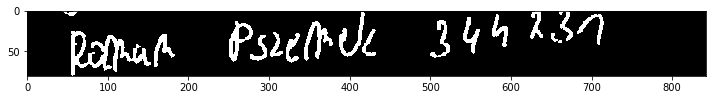

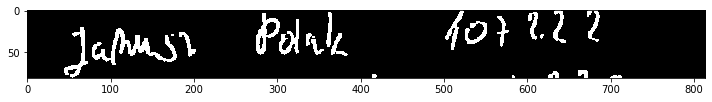

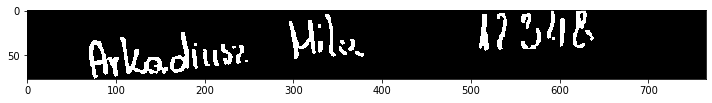

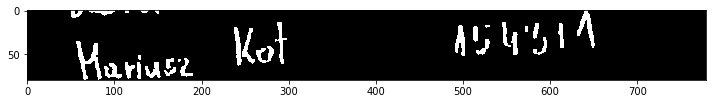

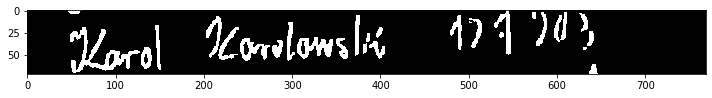

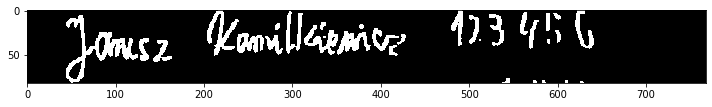

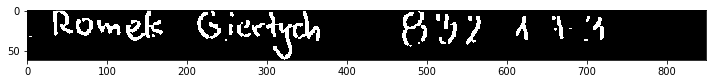

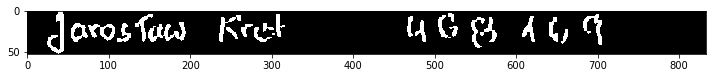

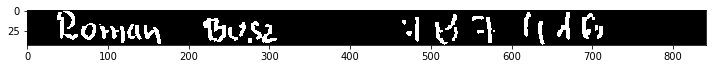

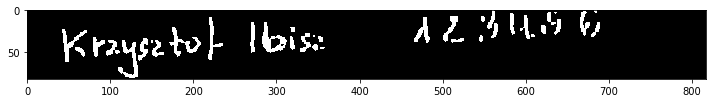

In [20]:
def split_rows(binary_image, plot=True, threshold=2, show_rows=True, offset=0, angle_offset=0):
    aera = get_text_aera(binary_image)
    rotated = rotate_text(aera, binary_image, angle_offset)
    upper, lower = find_boundries(rotated, threshold)
    
    if plot:
        drawing = draw_boundries(rotated, upper, lower)
        debug_plot_cv_img(drawing)
        
    return split(rotated, upper, lower, show_rows, offset)
        
def get_text_aera(binary_image): 
    pts = cv.findNonZero(binary_image)
    return cv.minAreaRect(pts)

def rotate_text(text_aera, binary_image, angle_offset=0):
    (cx,cy), (w,h), ang = text_aera
        
    M = cv.getRotationMatrix2D((cx,cy), ang+angle_offset, scale=1.0)
    rotated = cv.warpAffine(binary_image, M, (img.shape[1], img.shape[0]))
    return rotated

def find_boundries(img, threshold=2):
    hist = cv.reduce(img, 1, cv.REDUCE_AVG).reshape(-1)
    h,w = img.shape[:2]
    uppers = [y for y in range(h-1) if hist[y]<=threshold and hist[y+1]>threshold]
    lowers = [y for y in range(h-1) if hist[y]>threshold and hist[y+1]<=threshold]
    return uppers, lowers
    
def draw_boundries(img, upper, lower):
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    h, w = img.shape[:2]
    for y in upper:
        cv.line(img, (0,y), (w, y), (255,0,0), 1)

    for y in lower:
        cv.line(img, (0,y), (w, y), (0,255,0), 1)
        
    return img

def split(img, upper, lower, show=False, offset=0):
    assert len(upper) == len(lower)
    
    rows = []
    for i in range(len(upper)):
        upper_boundry = max(0, upper[i] - offset)
        lower_boundry = min(img.shape[0], lower[i] + offset)
#         image = img[upper[i]:lower[i], :]
        image = img[upper_boundry:lower_boundry, :]
        rows.append(image)
        
    if show:
        for row in rows:
            debug_plot_cv_img(row)
    
    return rows

plt.rcParams.update({'figure.max_open_warning': 0})
img = cv.imread("../data/20.png")

img = img[250:2300, 120:1000]
img = cv.GaussianBlur(img,(3,3),0)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## (2) threshold
# th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
threshed = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 7,5)
threshed = dilate(threshed, 4)
threshed = erode(threshed, 2)
# debug_plot_cv_img(threshed)
# rows = split_rows(threshed, plot=False, threshold=2, show_rows=False, offset=10, angle_offset=0)

from copy import deepcopy
R = threshed
R = deepcopy(R)
kenel_rect = cv.getStructuringElement(cv.MORPH_RECT, (256, 4))
#     R2 = erode(R, 0)
R2 = deepcopy(R)
# debug_plot_cv_img(R2)
R2 = erode(R2, 4)
R2 = dilate(R2, kernel=kenel_rect)
# debug_plot_cv_img(R2)
contours, _ = cv.findContours(R2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

rows = []

for i, c in enumerate(contours):
    boundRect = cv.boundingRect(c)
#     cv.rectangle(R, (int(boundRect[0]), int(boundRect[1])), \
#         (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (127,127,127), 2)
    
    row = R[boundRect[1]:boundRect[1]+boundRect[3], boundRect[0]:boundRect[0]+boundRect[2]].copy()
    rows.append(row)

    debug_plot_cv_img(row)
# words = split_rows(R,threshold=4, show_rows=True, offset=10, angle_offset=0)

rows__ = rows.copy()

In [8]:
img.shape[0]

2050

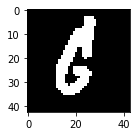

In [50]:
def place_in_center(img):
    img = img.astype(int)
    rows, cols = img.shape
    new_size = rows if rows > cols else cols
    
    new_image = np.zeros((new_size, new_size)).astype(int)
    
    x = int(new_size/2) - int(rows/2)
    y = int(new_size/2) - int(cols/2)
    
    new_image[x:x+rows, y:y+cols] = img 
    return new_image
    
    
t=place_in_center(test)
    
debug_plot_cv_img(t)

In [69]:
from PIL import Image

class WordsExtractor:
    
    @staticmethod
    def extract(row_image):
        kenel_rect = cv.getStructuringElement(cv.MORPH_RECT, (16, 64))
        img_copy = row_image.copy()
        img_copy = erode (img_copy, 4)
        img_copy = dilate(img_copy, kernel=kenel_rect)
        contours, _ = cv.findContours(img_copy, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        words = []

        for i, c in enumerate(contours):
            boundRect = cv.boundingRect(c)

#             cv.rectangle(row_test, (int(boundRect[0]), int(boundRect[1])), \
#                 (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (127,127,127), 1)

            word = row[boundRect[1]:boundRect[1]+boundRect[3], boundRect[0]:boundRect[0]+boundRect[2]].copy()
            words.append(word)
        
        return words
    
    
class DigitsExtractor:
    
    @staticmethod
    def extract(words_list):
        kenel_rect = cv.getStructuringElement(cv.MORPH_RECT, (4, 16))

        digits = []
        for word in words_list[:-2]: # words are in reverse order, so first element is the last word
                                     # we assume that the 2 first words are name & surname, so we skip it
            word_copy = word.copy()
            word_copy = erode (word_copy, 4)
            word_copy = dilate(word_copy, kernel=kenel_rect)
            contours, _ = cv.findContours(word_copy, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

            for i, c in enumerate(contours):
                boundRect = cv.boundingRect(c)

    #             cv.rectangle(row_test, (int(boundRect[0]), int(boundRect[1])), \
    #                 (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (127,127,127), 1)

                digit = word[boundRect[1]:boundRect[1]+boundRect[3], boundRect[0]:boundRect[0]+boundRect[2]].copy()
                digits.append(digit)

        rows_digits.append(digits)
        
        return [DigitsExtractor.format_for_mnist(d) for d in digits]
       
    
    @staticmethod
    def place_in_center(img):
        img = img.astype(int)
        rows, cols = img.shape
        new_size = rows if rows > cols else cols

        new_image = np.zeros((new_size, new_size)).astype(int)

        x = int(new_size/2) - int(rows/2)
        y = int(new_size/2) - int(cols/2)

        new_image[x:x+rows, y:y+cols] = img 
        return new_image
        

    @staticmethod
    def format_for_mnist(digit_image):
        t = digit_image
        t = DigitsExtractor.place_in_center(x).astype('uint8')
        t = Image.fromarray(t)
        t = t.resize((28,28), Image.ANTIALIAS)
        t = np.asarray(t)
        return t
        

In [66]:
kenel_rect = cv.getStructuringElement(cv.MORPH_RECT, (16, 64))

rows = rows__.copy()

rows_words = []
for row in rows[:]:
    row2 = row.copy()
    row2 = erode(row2, 4)
    row2 = dilate(row2, kernel=kenel_rect)
    contours, _ = cv.findContours(row2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    words = []
    row_test = row.copy()
    
    for i, c in enumerate(contours):
        boundRect = cv.boundingRect(c)

        cv.rectangle(row_test, (int(boundRect[0]), int(boundRect[1])), \
            (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (127,127,127), 1)

        word = row[boundRect[1]:boundRect[1]+boundRect[3], boundRect[0]:boundRect[0]+boundRect[2]].copy()
        words.append(word)
        
#     debug_plot_cv_img(row_test)
        
    rows_words.append(words)
#     for w in words[:-2]:
#         debug_plot_cv_img(w)

rows_words__ = rows_words.copy()

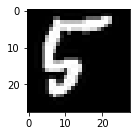

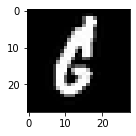

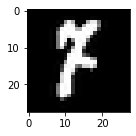

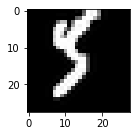

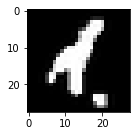

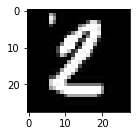

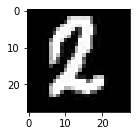

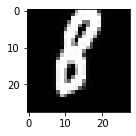

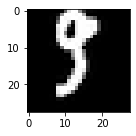

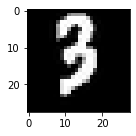

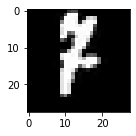

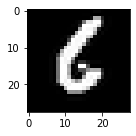

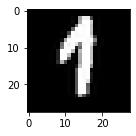

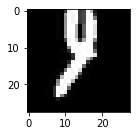

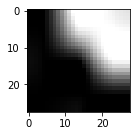

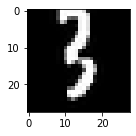

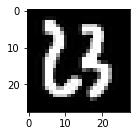

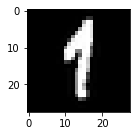

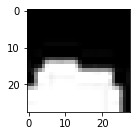

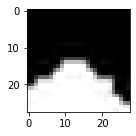

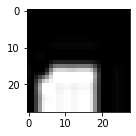

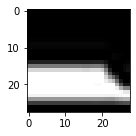

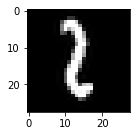

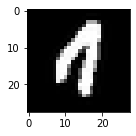

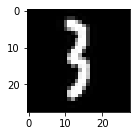

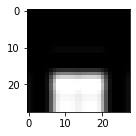

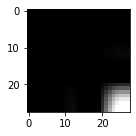

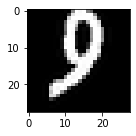

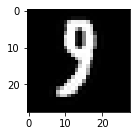

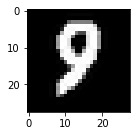

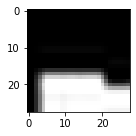

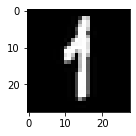

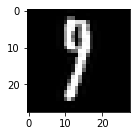

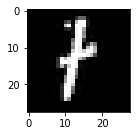

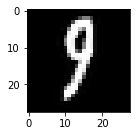

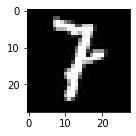

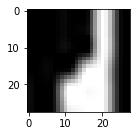

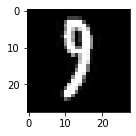

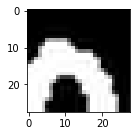

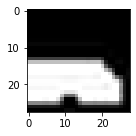

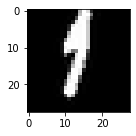

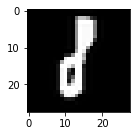

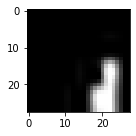

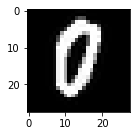

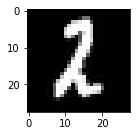

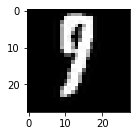

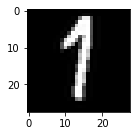

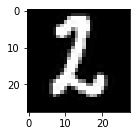

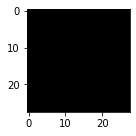

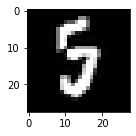

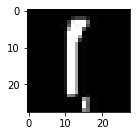

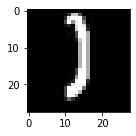

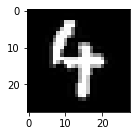

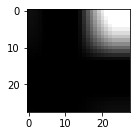

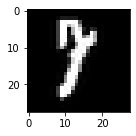

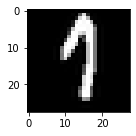

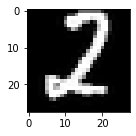

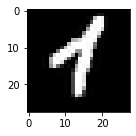

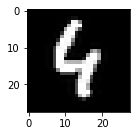

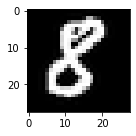

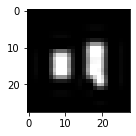

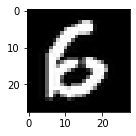

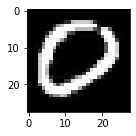

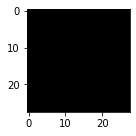

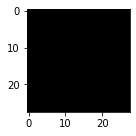

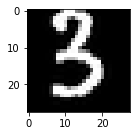

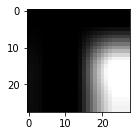

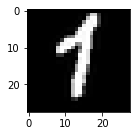

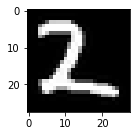

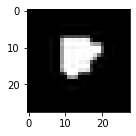

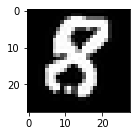

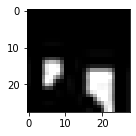

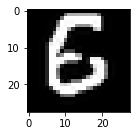

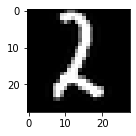

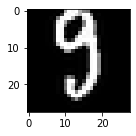

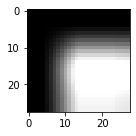

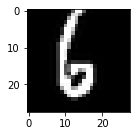

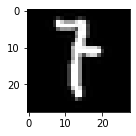

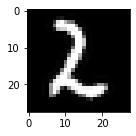

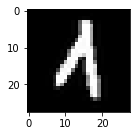

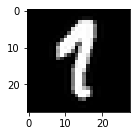

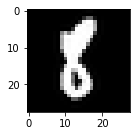

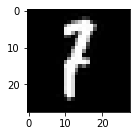

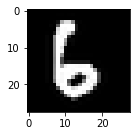

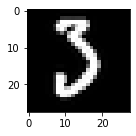

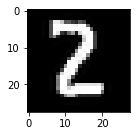

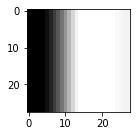

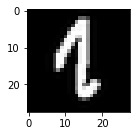

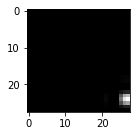

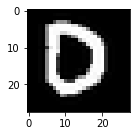

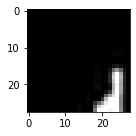

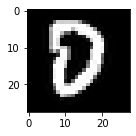

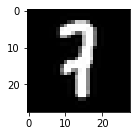

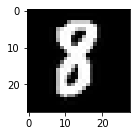

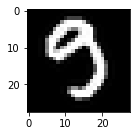

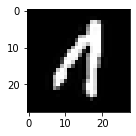

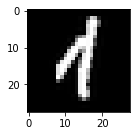

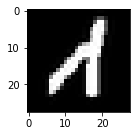

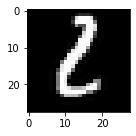

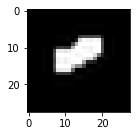

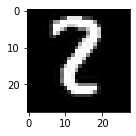

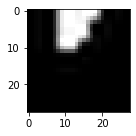

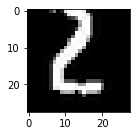

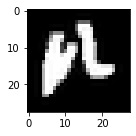

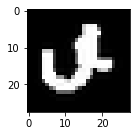

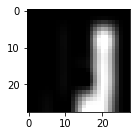

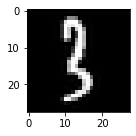

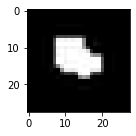

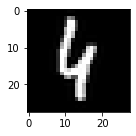

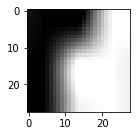

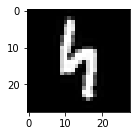

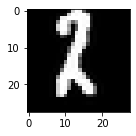

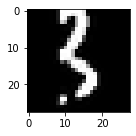

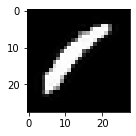

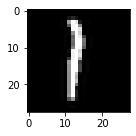

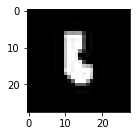

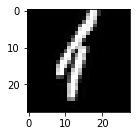

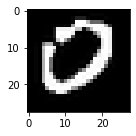

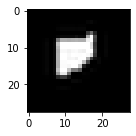

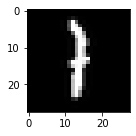

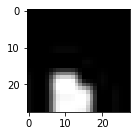

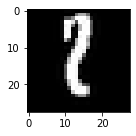

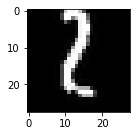

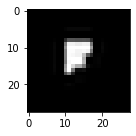

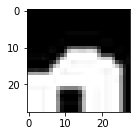

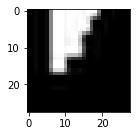

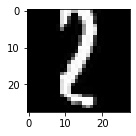

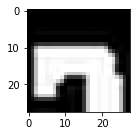

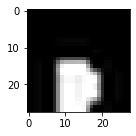

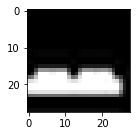

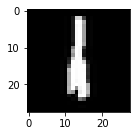

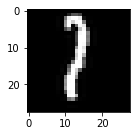

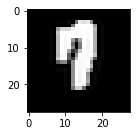

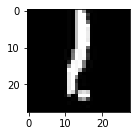

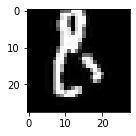

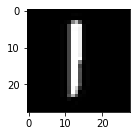

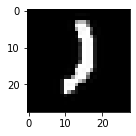

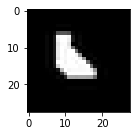

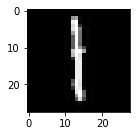

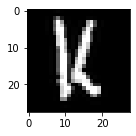

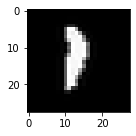

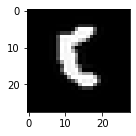

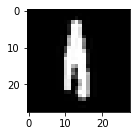

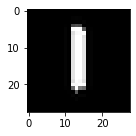

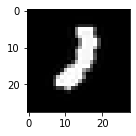

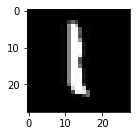

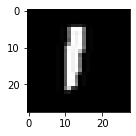

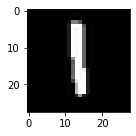

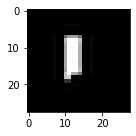

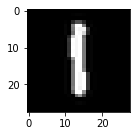

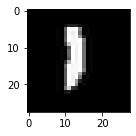

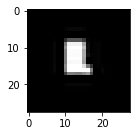

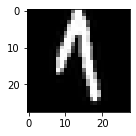

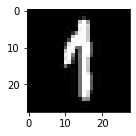

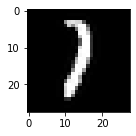

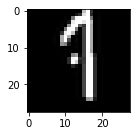

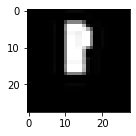

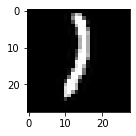

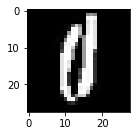

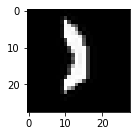

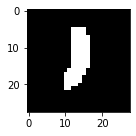

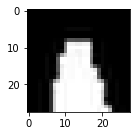

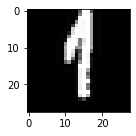

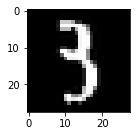

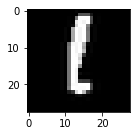

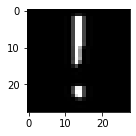

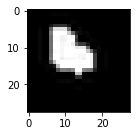

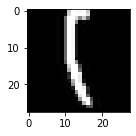

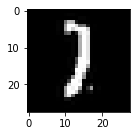

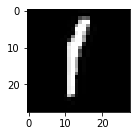

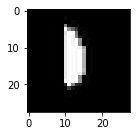

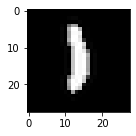

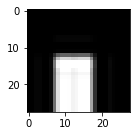

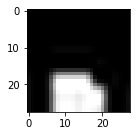

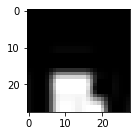

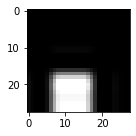

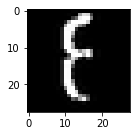

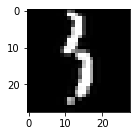

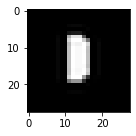

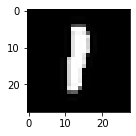

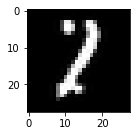

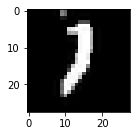

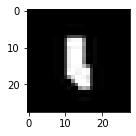

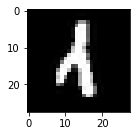

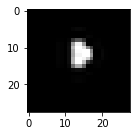

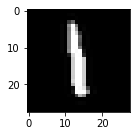

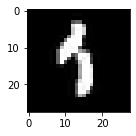

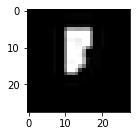

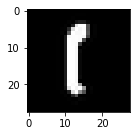

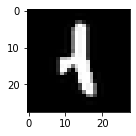

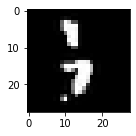

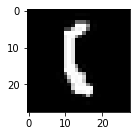

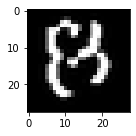

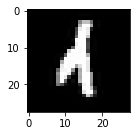

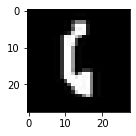

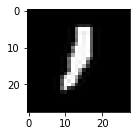

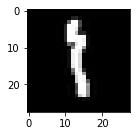

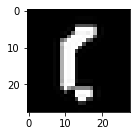

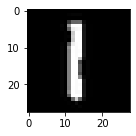

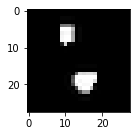

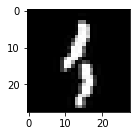

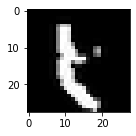

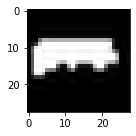

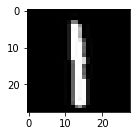

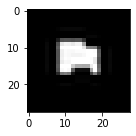

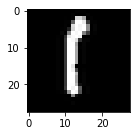

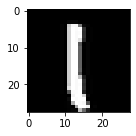

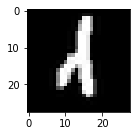

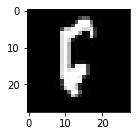

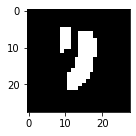

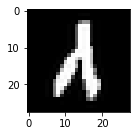

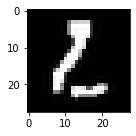

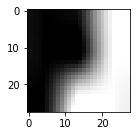

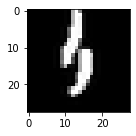

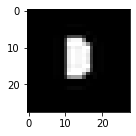

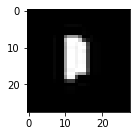

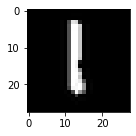

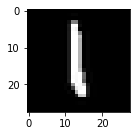

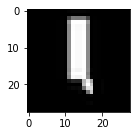

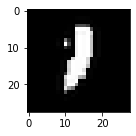

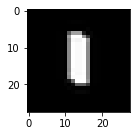

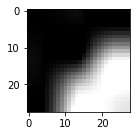

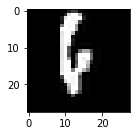

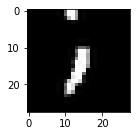

In [67]:
rows_words = rows_words__.copy()

kenel_rect = cv.getStructuringElement(cv.MORPH_RECT, (4, 16))

rows = rows__.copy()

rows_digits = []
for row_words in rows_words:
    
    digits = []
    for img in row_words[:-2]:
        row = img
        row2 = img.copy()
        row2 = erode(row2, 4)
        row2 = dilate(row2, kernel=kenel_rect)
        contours, _ = cv.findContours(row2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
        for i, c in enumerate(contours):
            boundRect = cv.boundingRect(c)

#             cv.rectangle(row_test, (int(boundRect[0]), int(boundRect[1])), \
#                 (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (127,127,127), 1)

            digit = row[boundRect[1]:boundRect[1]+boundRect[3], boundRect[0]:boundRect[0]+boundRect[2]].copy()
            digits.append(digit)

    #     debug_plot_cv_img(row_test)

    rows_digits.append(digits)
        
from PIL import Image
        
for w in rows_digits:
    for x in w[::-1]:
        t = place_in_center(x).astype('uint8')
        t = Image.fromarray(t)
        t = t.resize((28,28), Image.ANTIALIAS)
        t = np.asarray(t)
        
        debug_plot_cv_img(t)